In [1]:
import requests
import cairosvg
import os
import json
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import gc
import sys
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

2024-10-30 00:03:52.816701: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 00:03:52.830243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 00:03:52.844845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 00:03:52.848457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 00:03:52.861357: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#!pip install cairosvg
#tf.config.set_visible_devices([], 'GPU')

## 1 Carga de datos

In [3]:
def print_memory_usage():
    """
    Imprime el tamaño de todas las variables en memoria.
    """
    # Ejecutar el recolector de basura para liberar objetos no referenciados
    gc.collect()
    
    # Obtener las variables globales
    variables = globals().copy()
    
    # Mostrar el tamaño de cada variable
    print(f"{'Variable':<30} {'Size (MB)':>10}")
    print("-" * 40)
    for var_name, var_value in variables.items():
        size_mb = sys.getsizeof(var_value) / (1024 * 1024)
        print(f"{var_name:<30} {size_mb:>10.2f}")

In [4]:
DS_PATH = "../ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"

# Download if folder was not present
if not os.path.exists(DS_PATH):
    os.system(
        f"kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset -p {DS_PATH} --unzip"
    )

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

df.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


### 1.1 Procesamiento de los datos de entreda
        
    

In [9]:
# Definir tamaño para estadarizar imágenes
IMAGE_SIZE = (224,224)

# Carpeta para guardar las imágenes SVG y PNG localmente
SVG_FOLDER = "./svg_files"
PNG_FOLDER = "./svg_images"
augmented_dir = "./combined_images"

os.makedirs(SVG_FOLDER, exist_ok=True)
os.makedirs(PNG_FOLDER, exist_ok=True)

# Función para generar un color aleatorio en formato hexadecimal
def random_color():
    return "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )
    

# Función para descargar y convertir las imágenes SVG si no están descargadas, con fondo aleatorio
def download_and_convert_svg(url, sanskrit_name, index):
    # Definir rutas de archivos locales
    svg_filename = f"{sanskrit_name}_{index}.svg"
    png_dir = os.path.join(PNG_FOLDER, sanskrit_name)  # Crear una carpeta para cada clase usando el nombre en sánscrito
    os.makedirs(png_dir, exist_ok=True)
    png_filename = f"{sanskrit_name}_{index}.png"
    svg_path = os.path.join(SVG_FOLDER, svg_filename)
    png_path = os.path.join(png_dir, png_filename)
    
    # Descargar el archivo SVG solo si no existe localmente
    if not os.path.exists(svg_path):
        try:
            response = requests.get(url)
            if response.status_code == 200:
                with open(svg_path, 'wb') as svg_file:
                    svg_file.write(response.content)
                print(f"SVG descargado y guardado en: {svg_path}")
            else:
                print(f"Error al descargar la imagen desde: {url}")
                return None
        except Exception as e:
            print(f"Excepción al descargar la imagen: {e}")
            return None
    
    # Convertir el archivo SVG a PNG con un fondo aleatorio si aún no existe el archivo PNG
    if not os.path.exists(png_path):
        try:
            # Leer el contenido SVG y convertirlo en PNG con fondo aleatorio
            background_color = random_color()
            with open(svg_path, 'rb') as svg_file:
                svg_data = svg_file.read()
            
            cairosvg.svg2png(bytestring=svg_data, write_to=png_path, output_width=224, output_height=224, background_color=background_color)
            print(f"SVG convertido a PNG con fondo aleatorio en: {png_path}")
        except Exception as e:
            print(f"Excepción al convertir la imagen: {e}")
            return None
            
    return png_path

# Función para procesar las imágenes SVG en el DataFrame
def process_svg_images(df):
    svg_images = []
    labels = []
    
    for index, row in df.iterrows():
        svg_url = row['img_url']
        sanskrit_name = row['sanskrit_name'].replace(' ', '_')
        
        # Descargar y convertir la imagen SVG a PNG
        png_path = download_and_convert_svg(svg_url, sanskrit_name, index)
        if png_path:
            # Cargar la imagen convertida
            image = cv2.imread(png_path, cv2.IMREAD_UNCHANGED)
            if image is not None:
                # Verificar si la imagen tiene 4 canales y convertir a RGB
                if image.shape[2] == 4:
                    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
                
                # Redimensionar y normalizar
                image_resized = cv2.resize(image, IMAGE_SIZE)
                image_normalized = image_resized / 255.0  # Normalizar a [0, 1]
                svg_images.append(image_normalized)
                labels.append(sanskrit_name)
            else:
                print(f"Error al cargar la imagen convertida en: {png_path}")
    
    return np.array(svg_images), np.array(labels)

# Cargar el DataFrame de las imágenes SVG
DS_PATH = "../ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

# Cargar y procesar las imágenes SVG
svg_images, svg_labels = process_svg_images(df)

print(f"Imágenes SVG procesadas: {len(svg_images)}")



SVG convertido a PNG con fondo aleatorio en: ./svg_images/Navasana/Navasana_0.png
SVG descargado y guardado en: ./svg_files/Ardha_Navasana_1.svg
SVG convertido a PNG con fondo aleatorio en: ./svg_images/Ardha_Navasana/Ardha_Navasana_1.png
SVG convertido a PNG con fondo aleatorio en: ./svg_images/Dhanurasana/Dhanurasana_2.png
SVG descargado y guardado en: ./svg_files/Setu_Bandha_Sarvangasana_3.svg
SVG convertido a PNG con fondo aleatorio en: ./svg_images/Setu_Bandha_Sarvangasana/Setu_Bandha_Sarvangasana_3.png
SVG descargado y guardado en: ./svg_files/Baddha_Konasana_4.svg
SVG convertido a PNG con fondo aleatorio en: ./svg_images/Baddha_Konasana/Baddha_Konasana_4.png
SVG convertido a PNG con fondo aleatorio en: ./svg_images/Ustrasana/Ustrasana_5.png
SVG convertido a PNG con fondo aleatorio en: ./svg_images/Marjaryasana/Marjaryasana_6.png
SVG convertido a PNG con fondo aleatorio en: ./svg_images/Bitilasana/Bitilasana_7.png
SVG convertido a PNG con fondo aleatorio en: ./svg_images/Utkatasa

#### 1.1.1 Mostrar  procesameinto de las imágenes

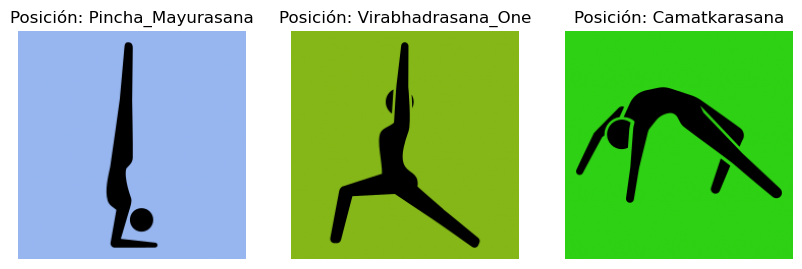

In [10]:
def show_random_images(images, labels, num_images=3):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_images):
        # Seleccionar un índice aleatorio
        idx = random.randint(0, len(images) - 1)
        
        # Seleccionar la imagen y la etiqueta correspondiente
        image = images[idx]
        label = labels[idx]
        
        # Crear un subplot
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Posición: {label}")
        plt.axis('off')
    
    plt.show()

show_random_images(svg_images, svg_labels)

### 2. entrenamiento con los SVG

La estrategia será crear un modelo de pre-entrenamiento con las imágenes simples SVG, y luego utilizar las reales

#### 2.1 Pre-entrenamiento con imágenes SVG

In [1]:

# Aumentación de Datos
# Definir un generador de datos con técnicas de data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

# Generador de datos para las imágenes SVG
train_generator_svg = train_datagen.flow_from_directory(
    PNG_FOLDER,
    target_size=(224, 224),
    batch_size=4,
    class_mode='sparse'
)
def plot_metrics(history):
    """
    Grafica la pérdida y precisión del entrenamiento y validación.
    
    Parámetros:
    - history: objeto de historial devuelto por el método fit() de Keras.
    """
    # Crear la figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfica de Pérdida
    ax1.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    if('val_loss' in history.history):
        ax1.plot(history.history['val_loss'], label='Pérdida de Validación')
    ax1.set_title('Pérdida durante el Entrenamiento')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Gráfica de Precisión
    ax2.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    if('val_accuracy' in history.history):
        ax2.plot(history.history['val_accuracy'], label='Precisión de Validación')
    ax2.set_title('Precisión durante el Entrenamiento')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)

    # Mostrar la figura
    plt.show()

# Definir el modelo funcional basado en la estructura proporcionada
def build_simple_cnn_model(input_shape2, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Primer bloque
    x1 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D(pool_size=(2, 2))(x1)
    
    # Global Average Pooling y salida final
    xfc = layers.GlobalAveragePooling2D()(x1)
    outputs = layers.Dense(num_classes, activation="softmax")(xfc)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Mostrar algunas imágenes del conjunto de entrenamiento
def mostrar_imagenes(imagenes, etiquetas, titulo):
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(imagenes[i].astype('uint8'))  # Convertir la imagen a uint8 para visualizar correctamente
        plt.title(f'Clase: {etiquetas[i]}')
        plt.axis('off')
    plt.suptitle(titulo)
    plt.show()

# Definir el número de clases según las imágenes en svg_images_dir
input_shape = (224, 224, 3)
num_classes = train_generator_svg.num_classes

# Construir el modelo
model = build_simple_cnn_model(input_shape, num_classes)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definir un callback de EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con las imágenes SVG
history = model.fit(
    train_generator_svg,
    epochs=200,
    steps_per_epoch=train_generator_svg.samples // train_generator_svg.batch_size,
    #callbacks=[early_stopping]
)



NameError: name 'ImageDataGenerator' is not defined

### Muestras de entrenamiento de los SVG

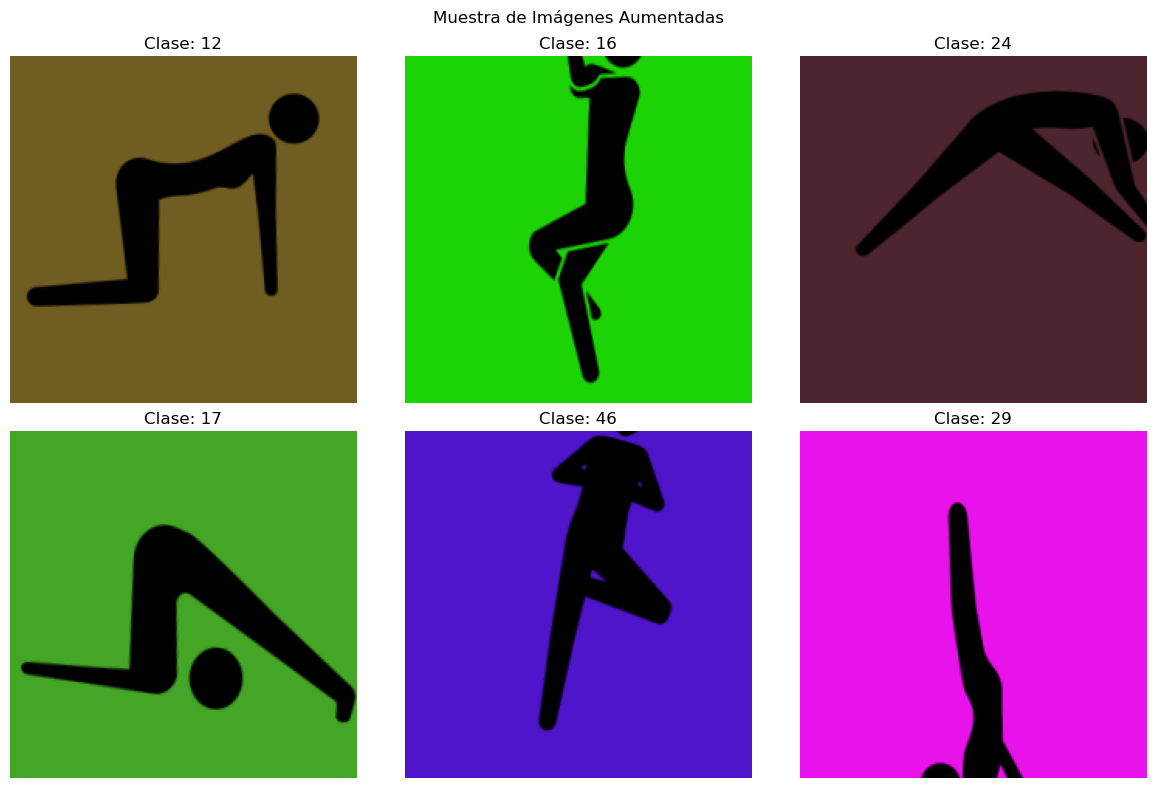

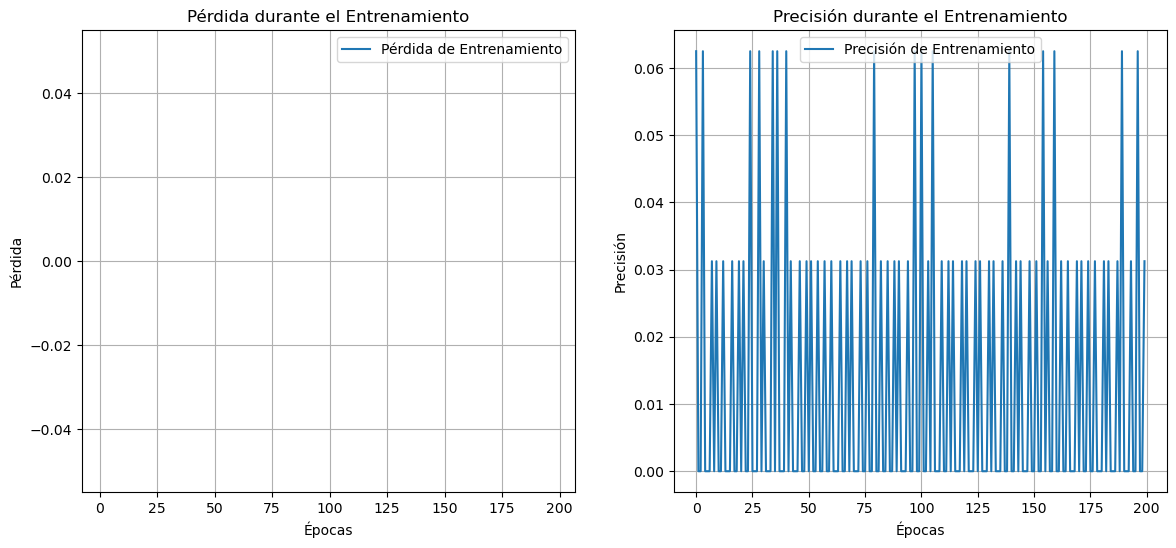

In [17]:
# Función para mostrar una muestra de las imágenes aumentadas
def mostrar_muestra_aumentada(generator, num_images=6):
    # Obtener un lote de imágenes aumentadas
    img_batch, label_batch = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(img_batch[i].astype('uint8'))
        plt.title(f'Clase: {int(label_batch[i])}')
        plt.axis('off')
    plt.suptitle('Muestra de Imágenes Aumentadas')
    plt.tight_layout()
    plt.show()

# Mostrar una muestra de las imágenes SVG aumentadas
mostrar_muestra_aumentada(train_generator_svg)
plot_metrics(history)

### Entrenar con imágenes reales

In [9]:
def preprocess_real_image(image_path, target_size=(224, 224)):
    """
    Preprocesa una imagen real: redimensiona, mantiene la relación de aspecto y rellena con un color aleatorio.
    
    Parámetros:
    - image_path: ruta de la imagen a procesar.
    - target_size: tamaño objetivo al que se redimensionará la imagen (ancho, alto).
    
    Retorna:
    - La imagen procesada con el tamaño especificado y normalizada.
    """
    # Leer la imagen
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error al cargar la imagen en {image_path}")
        return None
    
    # Obtener dimensiones originales
    original_height, original_width = image.shape[:2]
    target_width, target_height = target_size
    
    # Calcular el factor de escala para mantener la relación de aspecto
    scale = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    
    # Redimensionar la imagen manteniendo la relación de aspecto
    resized_image = cv2.resize(image, (new_width, new_height))
    
    # Generar un color de fondo aleatorio para los espacios vacíos
    random_color = [np.random.randint(0, 256) for _ in range(3)]
    
    # Crear una nueva imagen con el tamaño objetivo y rellenar con el color aleatorio
    processed_image = np.full((target_height, target_width, 3), random_color, dtype=np.uint8)
    
    # Calcular las coordenadas para centrar la imagen redimensionada
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    
    # Insertar la imagen redimensionada en el centro de la imagen final
    processed_image[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image
    
    # Normalizar la imagen
    processed_image = processed_image / 255.0  # Normalizar a [0, 1]
    
    return processed_image

def preprocess_png_images(ds_path, augmented_dir):
    png_images = []
    labels = []
    labels_prohibit = ['Ashta Chandrasana']

    # if os.path.exists(augmented_dir):
    #     return
        
    # Obtener todas las carpetas en ds_path y todos los archivos PNG
    folders = [folder for folder in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, folder))]
    files = [(folder, os.path.join(ds_path, folder, file)) for folder in folders for file in os.listdir(os.path.join(ds_path, folder)) if file.endswith('.png')]
    
    # Utilizar tqdm para mostrar la barra de progreso
    for folder, file_path in tqdm(files, desc="Procesando imágenes PNG"):
        # Preprocesar la imagen
        if(folder not in labels_prohibit):
            processed_image = preprocess_real_image(file_path, target_size=IMAGE_SIZE)
            if processed_image is not None:
                png_images.append(processed_image)
                labels.append(folder)  # El nombre de la carpeta es la etiqueta (en sánscrito)
    
    return np.array(png_images), np.array(labels)

# Aplicar el preprocesamiento a las imágenes PNG reales
png_images, png_labels = preprocess_png_images(DS_PATH, augmented_dir)


Procesando imágenes PNG: 100%|██████████| 2314/2314 [01:00<00:00, 38.42it/s]


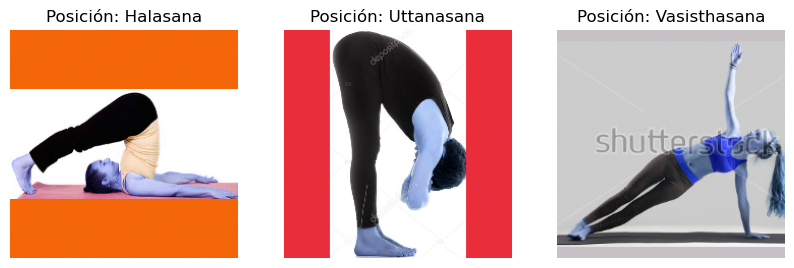

array(['Adho_Mukha_Svanasana', 'Adho_Mukha_Svanasana',
       'Adho_Mukha_Svanasana'], dtype='<U29')

In [11]:
show_random_images(png_images, png_labels)
def reemplazar_caracteres(s): 
    return s.replace(" ", "_")
png_labels = np.vectorize(reemplazar_caracteres)(png_labels)
display(png_labels[:3])


In [ ]:

def plot_images_per_label(labels):
    """
    Grafica la cantidad de imágenes por etiqueta (postura de yoga).
    
    Parámetros:
    - labels: lista o array con las etiquetas correspondientes a cada imagen.
    """
    # Contar la cantidad de imágenes por etiqueta
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Crear la gráfica
    plt.figure(figsize=(12, 8))
    plt.barh(unique_labels, counts, color='skyblue')
    plt.xlabel('Número de Imágenes')
    plt.ylabel('Etiquetas (Posturas)')
    plt.title('Cantidad de Imágenes por Etiqueta')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Usar la función para graficar las imágenes por etiqueta
plot_images_per_label(png_labels)


In [ ]:
del svg_images
gc.collect()  # Liberar memoria después de eliminar la variable
print_memory_usage()

### Hay muchos datos subrepresentados, se aplicará el aumento de datos selectivos de keras

In [ ]:

# def augment_images(images, labels, target_count):
#     """
#     Aplica aumento de datos selectivo para equilibrar las clases.
    
#     Parámetros:
#     - images: array con las imágenes originales.
#     - labels: array con las etiquetas correspondientes.
#     - target_count: número objetivo de imágenes por clase.
    
#     Retorna:
#     - augmented_images: array con las imágenes originales más las aumentadas.
#     - augmented_labels: array con las etiquetas correspondientes.
#     """
#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )
    
#     augmented_images = list(images)
#     augmented_labels = list(labels)
    
#     unique_labels, counts = np.unique(labels, return_counts=True)
#     label_to_count = dict(zip(unique_labels, counts))
    
#     for label in unique_labels[]:
#         # Solo aplicamos aumento de datos a las etiquetas que tienen menos imágenes que target_count
#         if label_to_count[label] < target_count:
#             # Filtrar las imágenes de esta clase
#             class_images = images[labels == label]
#             num_to_generate = target_count - label_to_count[label]
#             print(f"Generando {num_to_generate} imágenes para la etiqueta '{label}'")
            
#             # Generar imágenes adicionales utilizando aumento de datos
#             for i in range(num_to_generate):
#                 img = class_images[i % len(class_images)]
#                 img = np.expand_dims(img, 0)  # Expandir dimensiones para que sea compatible con datagen
#                 for batch in datagen.flow(img, batch_size=1):
#                     augmented_images.append(batch[0])
#                     augmented_labels.append(label)
#                     break  # Salir después de generar una imagen para este bucle
    
#     return np.array(augmented_images), np.array(augmented_labels)

# # Definir el número objetivo de imágenes por clase (por ejemplo, el máximo de imágenes de la clase más representada)
# max_images_per_class = max(np.unique(png_labels, return_counts=True)[1])

# # Aplicar aumento de datos selectivo
# augmented_images, augmented_labels = augment_images(png_images, png_labels, max_images_per_class)
# del png_images
# gc.collect()  # Liberar memoria después de eliminar la variable


In [ ]:

def save_original_and_augmented_images(images, labels, target_count, output_dir):
    """
    Guarda las imágenes originales y las aumentadas en disco solo si no existen.
    
    Parámetros:
    - images: array con las imágenes originales.
    - labels: array con las etiquetas correspondientes.
    - target_count: número objetivo de imágenes por clase.
    - output_dir: directorio donde se guardarán las imágenes originales y aumentadas.
    """
    # Verificar si el directorio ya existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterar sobre cada etiqueta en el conjunto de datos
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_to_count = dict(zip(unique_labels, counts))
    
    for label in unique_labels:
        # Ruta de la carpeta para la etiqueta actual
        label_dir = os.path.join(output_dir, label)
        
        # Si la carpeta ya existe y no está vacía, saltar a la siguiente etiqueta
        if os.path.exists(label_dir) and len(os.listdir(label_dir)) > 0:
            print(f"La carpeta para la etiqueta '{label}' ya existe y contiene imágenes. Usándola tal como está.")
            continue
        
        # Si la carpeta no existe, crearla
        os.makedirs(label_dir, exist_ok=True)
        
        # Filtrar las imágenes de esta clase
        class_images = images[labels == label]
        
        # Guardar las imágenes originales en el disco
        for idx, img in enumerate(class_images):
            img_path = os.path.join(label_dir, f"original_{idx}.png")
            cv2.imwrite(img_path, (img * 255).astype(np.uint8))
        
        # Calcular cuántas imágenes aumentar
        num_to_generate = target_count - label_to_count[label]
        if num_to_generate > 0:
            print(f"Generando {num_to_generate} imágenes para la etiqueta '{label}'")
            
            # Generar imágenes adicionales utilizando aumento de datos y guardarlas en disco
            # datagen = ImageDataGenerator(
            #     rotation_range=20,
            #     width_shift_range=0.2,
            #     height_shift_range=0.2,
            #     zoom_range=0.2,
            #     horizontal_flip=True,
            #     fill_mode='nearest'
            #)
            # train_datagen = ImageDataGenerator(
            #     rescale=1./255,
            #     rotation_range=40,
            #     width_shift_range=0.2,
            #     height_shift_range=0.2,
            #     shear_range=0.2,
            #     zoom_range=0.2,
            #     horizontal_flip=True,
            #     fill_mode='nearest',
            #     validation_split=0.2
            # )
            
            for i in tqdm(range(num_to_generate), desc=f"Procesando etiqueta '{label}'"):
                img = class_images[i % len(class_images)]
                img = np.expand_dims(img, 0)  # Expandir dimensiones para que sea compatible con datagen

                 # Generar un color aleatorio para el fondo
                random_color = np.random.randint(0, 256)
                
                # Configurar el generador de datos con el color aleatorio como valor de relleno (cval)
                datagen = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='constant',  # Usamos 'constant' para usar un color específico
                    cval=random_color  # Color aleatorio para los píxeles vacíos
                )
                for batch in datagen.flow(img, batch_size=1):
                    img_aug = (batch[0] * 255).astype(np.uint8)
                    file_name = f"aug_{i}.png"
                    file_path = os.path.join(label_dir, file_name)
                    cv2.imwrite(file_path, img_aug)  # Guardar la imagen en disco
                    break  # Salir después de generar una imagen para este bucle


# Directorio donde se guardarán las imágenes originales y aumentadas

max_images_per_class = max(np.unique(png_labels, return_counts=True)[1])
max_images_per_class = max_images_per_class + 200
# Aplicar aumento de datos y guardar en disco junto con las imágenes originales
save_original_and_augmented_images(png_images, png_labels, max_images_per_class, augmented_dir)



In [ ]:
import matplotlib.pyplot as plt
import os

def plot_label_distribution(directory):
    """
    Grafica la cantidad de imágenes por etiqueta (postura de yoga) en el directorio dado.
    
    Parámetros:
    - directory: ruta del directorio que contiene las carpetas de las etiquetas.
    """
    labels = []
    counts = []
    
    # Recorrer todas las carpetas en el directorio
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            # Contar el número de archivos en cada carpeta (etiqueta)
            num_images = len([file for file in os.listdir(label_dir) if file.endswith('.png')])
            labels.append(label)
            counts.append(num_images)
    
    # Crear la gráfica de barras
    plt.figure(figsize=(12, 8))
    plt.barh(labels, counts, color='skyblue')
    plt.xlabel('Número de Imágenes')
    plt.ylabel('Etiquetas (Posturas)')
    plt.title('Distribución de Imágenes por Etiqueta Después del Aumento de Datos')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Usar la función para graficar la distribución de imágenes por etiqueta
plot_label_distribution(augmented_dir)


In [ ]:
del png_images
gc.collect()  # Liberar memoria después de eliminar la variable
print_memory_usage()

In [ ]:
#Se configura el generador de datos apra cargar las iaágenes desde el disco para liberar RAM

# Crear el generador de datos para el entrenamiento y validación
train_datagen = ImageDataGenerator(    
    validation_split=0.2  # Dividir el conjunto en entrenamiento y validación
)

# Configurar el generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    augmented_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

# Configurar el generador para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    augmented_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)
print(train_generator.class_indices)


In [ ]:

# Obtener una muestra de elementos del generador de entrenamiento
train_images, train_labels = next(train_generator)

# Obtener una muestra de elementos del generador de validación
validation_images, validation_labels = next(validation_generator)


mostrar_imagenes(train_images, train_labels, "Muestra de imágenes del conjunto de entrenamiento")
mostrar_imagenes(validation_images, validation_labels, "Muestra de imágenes del conjunto de validación")


### Crear modelo con las imagenes reales

In [ ]:
# Cargar los pesos preentrenados
# def build_model_with_pretrained_weights(input_shape, num_classes, weights_path):
#     """
#     Construye un modelo CNN utilizando los pesos preentrenados y ajusta la última capa.
    
#     Parámetros:
#     - input_shape: tupla que define las dimensiones de entrada (alto, ancho, canales).
#     - num_classes: número de clases en el conjunto de datos real.
#     - weights_path: ruta al archivo con los pesos preentrenados.

#     Retorna:
#     - model: modelo CNN con los pesos cargados y la última capa ajustada.
#     """
#     # Definir el modelo con la misma arquitectura que se usó durante el preentrenamiento
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(256, activation='relu'),
#         Dense(128, activation='relu')  # Capa densa que coincide con la estructura original
#     ])
    
#     # Cargar los pesos preentrenados en el modelo hasta esta capa
#     # model.load_weights(weights_path)

#     # Ahora ajustamos la última capa para que coincida con el número de clases en el nuevo conjunto de datos
#     model.add(Dense(num_classes, activation='softmax'))
    
#     return model

def build_functional_cnn_model(input_shape, num_classes):
    # Definir la entrada
    inputs = layers.Input(shape=input_shape)

    # Primer bloque de capas
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    # Segundo bloque de capas
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(0.002))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Tercer bloque de capas
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(0.002))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    # Global Average Pooling en lugar de Flatten para reducir parámetros
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Capa densa final con salida para la clasificación
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Definir el modelo
    model = models.Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
# Asumimos que las imágenes tienen 3 canales (RGB)
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print(f"input_shape: {input_shape}")
# Obtener el número de clases a partir del generador
num_classes = train_generator.num_classes
print(f"num_classes: {num_classes}")


model = build_functional_cnn_model(input_shape,num_classes)
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Reduce la tasa de aprendizaje si se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con los generadores
calc_step_epoch = (train_generator.samples + train_generator.batch_size -1)// train_generator.batch_size
calc_step_validation = (validation_generator.samples + validation_generator.batch_size -1) // validation_generator.batch_size
print(f"{calc_step_epoch}, {calc_step_validation}")

images, labels = next(train_generator)
print(f"Train batch shape: {images.shape}, {labels.shape}")

images, labels = next(validation_generator)
print(f"Validation batch shape: {images.shape}, {labels.shape}")

class TerminateOnNaN(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        if loss is None or loss == 0.0 or loss != loss:  # NaN check (loss != loss is true if loss is NaN)
            print(f"Warning: Ending training at epoch {epoch + 1} due to NaN or zero loss.")
            self.model.stop_training = True

terminate_on_nan = TerminateOnNaN()

fine_tune_history = model.fit(
    train_generator,
    epochs=4,
    validation_data=validation_generator,
    steps_per_epoch=calc_step_epoch,
    validation_steps=calc_step_validation,
    callbacks=[terminate_on_nan]
    #callbacks=[early_stopping,reduce_lr]
)





In [ ]:
plot_metrics(fine_tune_history)